### Basic cell averaging methods check

In [1]:
import underworld as uw
import underworld.visualisation as vis
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
uw.utils.matplotlib_inline()


### averaging methods
from scipy.stats import gmean, hmean

## Set up the mesh

Initialise a Q1 finite element mesh and mesh variables

In [2]:
deformedmesh = True

elementType = "Q1"
resX = 2
resY = 1
mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = (resX, resY), 
                                 minCoord    = (-1., -1.), 
                                 maxCoord    = (1., 0.)) 



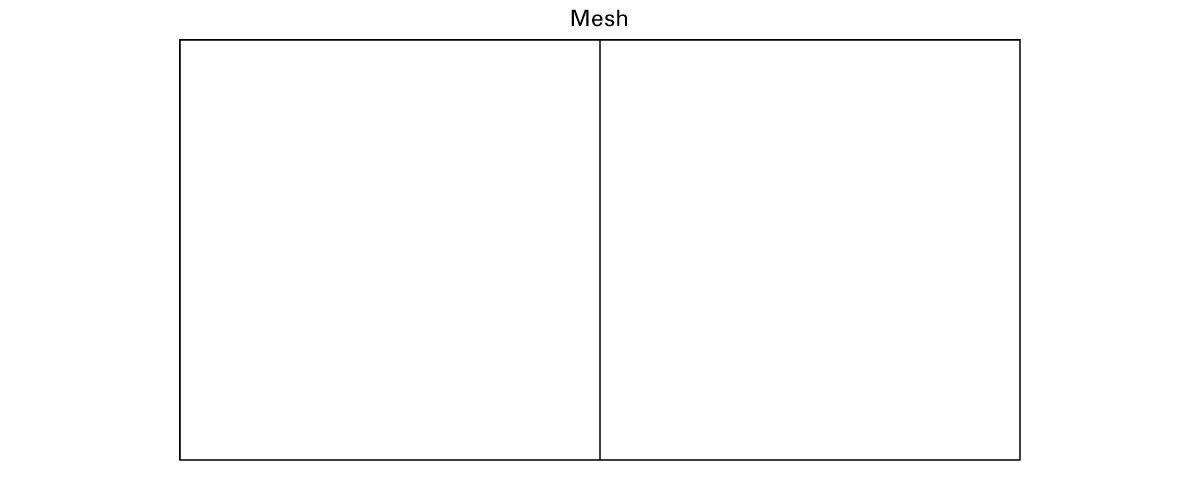

In [3]:
figMaterial = vis.Figure( figsize=(1200,500), title="Mesh" )
figMaterial.append( vis.objects.Mesh(mesh))
figMaterial.show()

In [4]:
GPC = 4
swarm         = uw.swarm.Swarm( mesh=mesh )
swarmLayout = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm,gaussPointCount=GPC)
swarm.populate_using_layout( layout=swarmLayout )

In [5]:
materialIndex        = swarm.add_variable( dataType="int",    count=1 )
hydraulicDiffusivity = swarm.add_variable( dataType="double", count=1 )
cellCentroids = swarm.add_variable( dataType="double", count=2 )

In [6]:
### used to calculate the inverse distance weighted mean
swarm0         = uw.swarm.Swarm( mesh=mesh )
swarmLayout0 = uw.swarm.layouts.PerCellGaussLayout(swarm=swarm0,gaussPointCount=1)
swarm0.populate_using_layout( layout=swarmLayout0 )

cell_centroids = swarm0.data[:]
cellCentroids.data[:] = np.repeat(cell_centroids, GPC**mesh.dim, axis=0)

In [7]:
materialIndex.data[:] = 1.

In [8]:
### randomise the hydraulic diffusivity
hydraulicDiffusivity.data[:,0] =  np.random.rand(materialIndex.data[:].shape[0]) # np.random.randint(1,3, size=materialIndex.data[:].shape[0]) 

materialIndex.data[:,0] = hydraulicDiffusivity.data[:,0]
### copy hydraulic diffusivity so the original can be reset later when checking different methods
initialHD = hydraulicDiffusivity.data[:,0].copy()
   


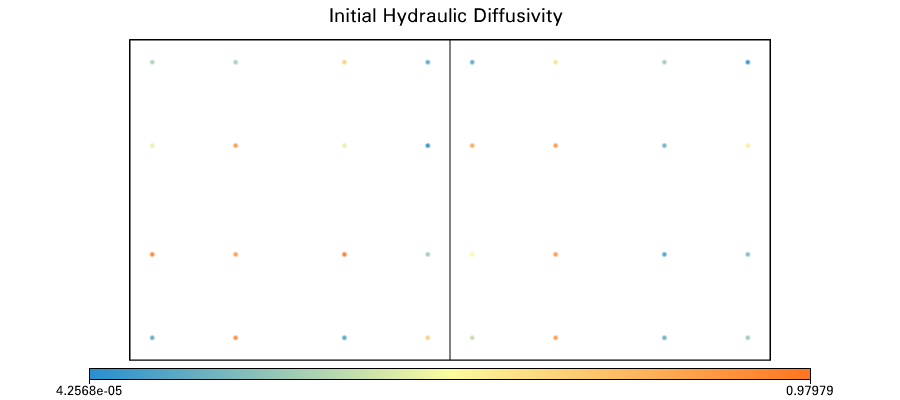

In [9]:
figHD = vis.Figure( figsize=(900,400), title="Initial Hydraulic Diffusivity" )
figHD.append( vis.objects.Points(swarm, hydraulicDiffusivity, pointSize=6.0) )
figHD.append( vis.objects.Mesh(mesh))
figHD.show()

In [10]:
import timeit

In [11]:
def arithmetic_mean():
    hydraulicDiffusivity.data[:,0] = np.repeat((np.mean((np.split(hydraulicDiffusivity.data[:,0], np.unique(swarm.owningCell.data[:,0], return_index = True)[1])[1:]), axis=1)), GPC**mesh.dim)

def harmonic_mean():
    hydraulicDiffusivity.data[:,0] = np.repeat((hmean((np.split(hydraulicDiffusivity.data[:,0], np.unique(swarm.owningCell.data[:,0], return_index = True)[1])[1:]), axis=1)), GPC**mesh.dim)

def geometric_mean():
    hydraulicDiffusivity.data[:,0] = np.repeat((gmean((np.split(hydraulicDiffusivity.data[:,0], np.unique(swarm.owningCell.data[:,0], return_index = True)[1])[1:]), axis=1)), GPC**mesh.dim)

def simple_idw():    
    for i in np.unique(swarm.owningCell.data[:,0]):
        '''     
        Calculates distance between swarm and the centroid in first cell only (of each CPU if running in parallel), 
        as the particle distribution *should* be the same in each cell. Can be removed to calculate the distance in 
        each cell if particles move or a different initial distribution is used.
        Bit slow as it is a for loop, needs optimisation...
        '''
        if i == swarm.owningCell.data[:,0].min(): 
            if mesh.dim == 2:
                x = (hydraulicDiffusivity.swarm.data[:,0][swarm.owningCell.data[:,0] == i] - cellCentroids.data[:,0][swarm.owningCell.data[:,0] == i])
                y = (hydraulicDiffusivity.swarm.data[:,1][swarm.owningCell.data[:,0] == i] - cellCentroids.data[:,1][swarm.owningCell.data[:,0] == i])
                distance = np.sqrt(x**2+y**2)
            elif mesh.dim == 3:
                x = (hydraulicDiffusivity.swarm.data[:,0][swarm.owningCell.data[:,0] == i] - cellCentroids.data[:,0][swarm.owningCell.data[:,0] == i])
                y = (hydraulicDiffusivity.swarm.data[:,1][swarm.owningCell.data[:,0] == i] - cellCentroids.data[:,1][swarm.owningCell.data[:,0] == i])
                z = (hydraulicDiffusivity.swarm.data[:,2][swarm.owningCell.data[:,0] == i] - cellCentroids.data[:,2][swarm.owningCell.data[:,0] == i])
                distance = np.sqrt(x**2+y**2+z**2)
    
            weights = 1.0 / distance
            weights /= weights.sum(axis=0)
        else: 
            pass
    
    
        IDW = np.dot(weights, hydraulicDiffusivity.data[:,0][swarm.owningCell.data[:,0] == i])
        # print(IDW)
        hydraulicDiffusivity.data[:,0][swarm.owningCell.data[:,0] == i] = np.repeat(IDW, GPC**mesh.dim)

    
    


53.6 µs ± 845 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)



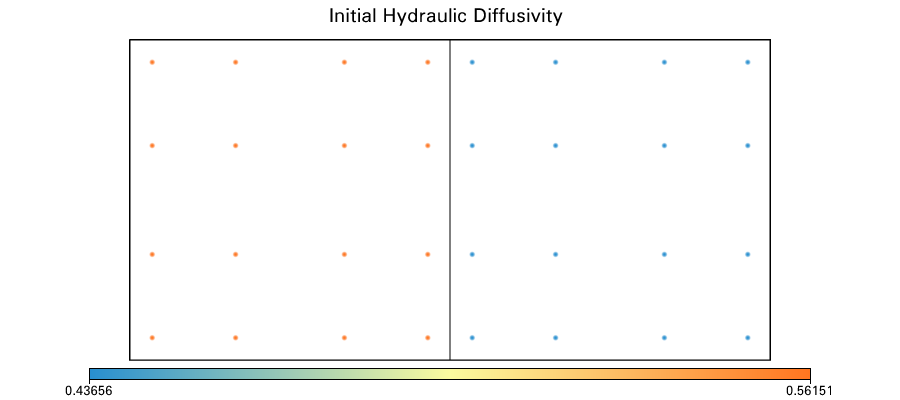

In [12]:
hydraulicDiffusivity.data[:,0] = initialHD
%timeit simple_idw()
figHD.show()
# 53.2 µs ± 1.35 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

33.7 µs ± 731 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)



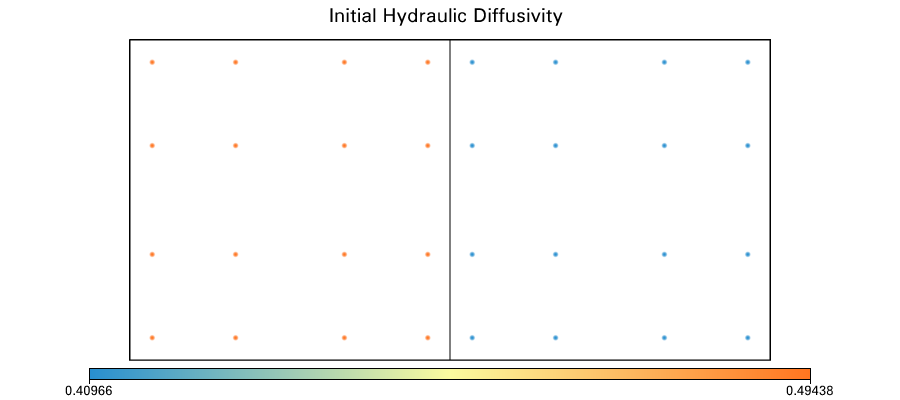

In [13]:
hydraulicDiffusivity.data[:,0] = initialHD

%timeit arithmetic_mean()

figHD.show()

# 34.6 µs ± 407 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

46.8 µs ± 621 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)



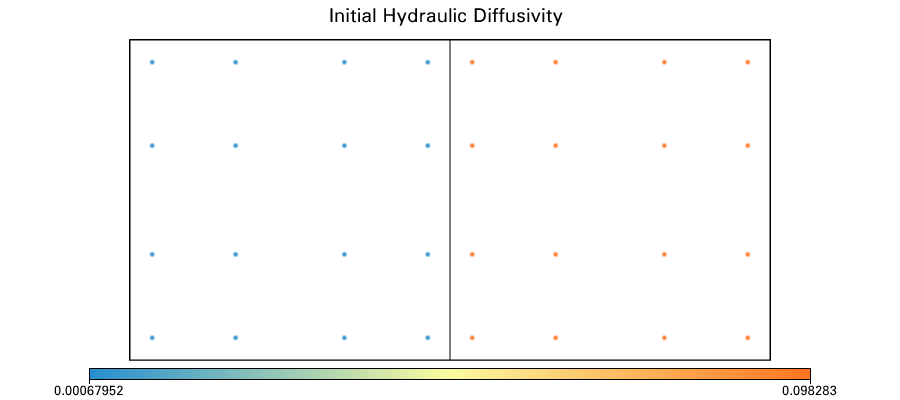

In [14]:
hydraulicDiffusivity.data[:,0] = initialHD

%timeit harmonic_mean()

figHD.show()

# 48.9 µs ± 860 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

36.4 µs ± 745 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)



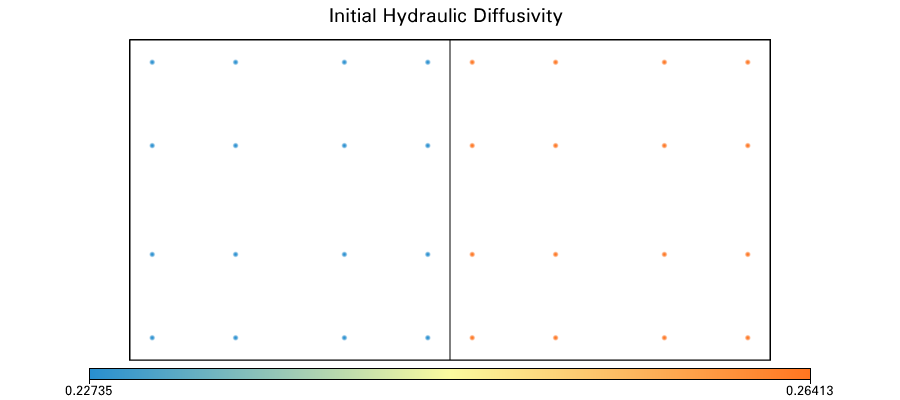

In [15]:
hydraulicDiffusivity.data[:,0] = initialHD

%timeit geometric_mean()

figHD.show()
# 37.9 µs ± 967 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)